In [2]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import sys
import yaml
sys.path.append('.')
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import seaborn as sns
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
import eval
import tensorflow as tf
from ml_collections.config_dict import ConfigDict

import models.diffusion
from models.diffusion_utils import generate
from models.train_utils import create_input_iter
from analysis_utils import envs

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

2024-02-19 14:20:42.416115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 14:20:42.416160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 14:20:42.417325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 14:20:44.572183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# model_name = 'wdm/balmy-sun-69'
model_name = 'wdm/dulcet-music-70'
rng = jax.random.PRNGKey(42)
steps = 500
dataset_root = None
dataset_name = None
num_particles = 50

In [4]:
# load the config
path_to_model = envs.DEFAULT_LOGGING_DIR / model_name
with open(path_to_model / "config.yaml", "r") as file:
    config = yaml.safe_load(file)
config = ConfigDict(config)

if dataset_root is None:
    dataset_root = config.data.dataset_root
if dataset_name is None:
    dataset_name = config.data.dataset_name

# get normalization dictionary from the training dataset
_, _, _, norm_dict = datasets.get_nbody_data(
    dataset_root,
    dataset_name,
    config.data.n_features,
    config.data.n_particles,
    conditioning_parameters=config.data.conditioning_parameters,
)

# load the model
vdm, params = models.diffusion.VariationalDiffusionModel.from_path_to_model(
    path_to_model=path_to_model, norm_dict=norm_dict)

### SN1

In [5]:
# simulation parameters
num_bins = 5
num_repeats = 100
log_m0 = 12.0
m_wdm = 10
agn1 = 0.1
sn2 = 7.0
sn1 = np.logspace(np.log10(0.1), np.log10(15), num_bins)

# create conditioning parameters
condition = np.zeros((num_bins * num_repeats, 5))
condition[:, 0] = log_m0
condition[:, 1] = m_wdm
condition[:, 3] = sn2
condition[:, 4] = agn1
condition[:, 2] = np.repeat(sn1, num_repeats)
condition = jnp.array(condition)

mask = jnp.ones(
    (num_bins * num_repeats, num_particles), dtype=jnp.float32)

# generate samples
samples = eval.generate_samples(
    vdm=vdm,
    params=params,
    rng=rng,
    n_samples=len(condition),
    n_particles=num_particles,
    conditioning=condition,
    mask=mask,
    steps=steps,
    norm_dict=norm_dict,
    boxsize=1,
)
samples = np.array(samples)

In [6]:
def get_histogram_q(samples, bins, q, cumulative=False):
    """ Compute the qth percentile of a samples of histograms. """
    counts = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    counts = np.stack(counts, axis=0)
    if cumulative:
        counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    return counts_q

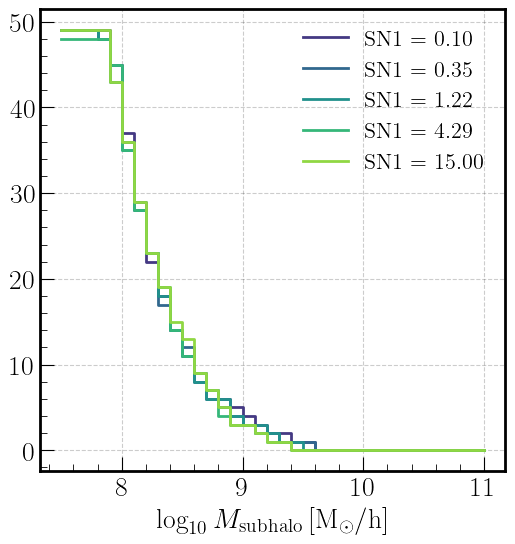

In [7]:
q = [0.5, 0.16, 0.84]
bins = np.arange(7.5, 11. + 0.1, 0.1)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, ax = plt.subplots()

log_mass = samples[..., 6]
sn1 = condition[::num_repeats, 2]
colors = sns.color_palette('viridis', len(sn1))

for i in range(len(sn1)):
    log_mass_samples = log_mass[i * num_repeats:(i + 1) * num_repeats]
    counts_q = get_histogram_q(log_mass_samples, bins, q, cumulative=True)

    label = r'SN1 = {:.2f}'.format(sn1[i])
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2, 
        label=label)

# ax.set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
ax.set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
ax.legend(fontsize=16)

plt.show()

### SN2

In [84]:
# simulation parameters
num_bins = 3
num_repeats = 1000
log_m0 = 12.0
m_wdm = 10
sn1 = 5.0
sn2 = 1/np.linspace(1/0.1, 1/10, num_bins).repeat(num_repeats)
agn1 = 0.1

# create conditioning parameters
condition = np.zeros((num_bins * num_repeats, 5))
condition[:, 0] = log_m0
condition[:, 1] = m_wdm
condition[:, 2] = sn1
condition[:, 3] = sn2
condition[:, 4] = agn1
condition = jnp.array(condition)

mask = jnp.ones(
    (num_bins * num_repeats, num_particles), dtype=jnp.float32)

# generate samples
samples = eval.generate_samples(
    vdm=vdm,
    params=params,
    rng=rng,
    n_samples=len(condition),
    n_particles=num_particles,
    conditioning=condition,
    mask=mask,
    steps=steps,
    norm_dict=norm_dict,
    boxsize=1,
)
samples = np.array(samples)

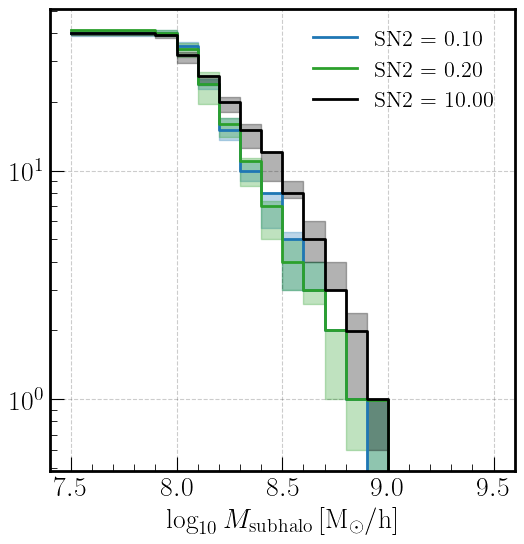

In [88]:
q = [0.5, 0.16, 0.84]
bins = np.arange(7.5, 9.5 + 0.1, 0.1)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, ax = plt.subplots()

log_mass = samples[..., 6]
sn2 = condition[::num_repeats, 3]
# colors = sns.color_palette('viridis', len(sn2))
colors = ['C0', 'C2', 'k', 'k']

for i in range(len(sn2)):
    log_mass_samples = log_mass[i * num_repeats:(i + 1) * num_repeats]
    counts_q = get_histogram_q(log_mass_samples, bins, q, cumulative=True)

    label = r'SN2 = {:.2f}'.format(sn2[i])
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2, 
        label=label)
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color=colors[i], alpha=0.3)
ax.set_yscale('log')

# ax.set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
ax.set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
ax.legend(fontsize=16)

plt.show()